In [101]:
%matplotlib notebook
import numpy as np
from commpy import PSKModem, QAMModem
from matplotlib import pyplot as plt
from matplotlib import pyplot  
from scipy.signal import find_peaks


In [102]:
def plot_m(objs):
    plt.close("all")
    M = len(objs)
    fig, ax = plt.subplots(M)
    for i in range(M):
        if objs[i] is tuple:
            x, y = objs[i]
            ax[i].plot(x, y)
            pass
        else:
            ax[i].plot(objs[i])
    plt.show()

In [103]:
#
# Set up the constellation and some constants for QPSK
##
nsymbols=4
repeats_per_symbol = 5
samples_per_second = 1000  
message_len = 3000
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 3000 # fc center frequency 
noise_sd = 0.75 # trying no noise at all 
# calculate
duration = total_samples//samples_per_second
time = np.linspace(0, duration, total_samples)/samples_per_second  # clock time of each sample
dt = duration/(total_samples*samples_per_second)

freqs = np.fft.ifftshift(np.fft.fftfreq(len(time), dt))
print(f" Set Fs: {1/dt} \n Set dt: {dt} \n Total_Samples: {len(time)}")


params = {
    'nsymbols':nsymbols,
    'repeats_per_symbol'   :  repeats_per_symbol,
    'samples_per_second'  :   samples_per_second,
    'message_len'   :   message_len ,
    'total_samples'  :  total_samples ,
    'baseband_carrier_freq' :   baseband_carrier_freq,
    'noise_sd'  :   noise_sd ,
    'duration' :  duration, 
    'time'  :   time, 
    'dt'  :   dt,
    'freqs'  :   freqs
    }

 Set Fs: 1000000.0 
 Set dt: 1e-06 
 Total_Samples: 15000


[0.00000000e+00 1.00006667e-06 2.00013334e-06 3.00020001e-06
 4.00026668e-06 5.00033336e-06 6.00040003e-06 7.00046670e-06
 8.00053337e-06 9.00060004e-06]
(1.0000000000000002+0j)
(0.9999999999999998+0j)


<IPython.core.display.Javascript object>


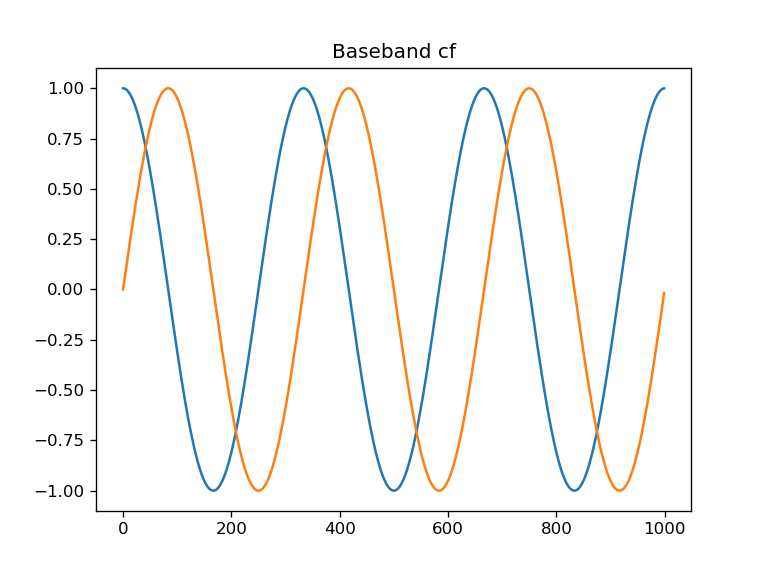

In [104]:

#
# Setup the baseband
#
print(time[:10])
baseband_signal =  np.exp(1j*2*np.pi*time*baseband_carrier_freq)

baseband_inv = np.exp(-1j*2*np.pi*time*baseband_carrier_freq)

assert np.all(np.abs(baseband_signal*baseband_inv) -1. < 0.00001)
print(np.max(baseband_signal*baseband_inv))
print(np.min(baseband_signal*baseband_inv))

#
# This inverses may not match intuition. Probably they
# would if we plotted a dot rotating on a circle,
# but do note that we mathematically asserted
# the composition of the two functions is 1, which is the definition of inverse.
#
pyplot.close("all")
pyplot.plot(np.real(baseband_signal[:1000]))
pyplot.plot(np.imag(baseband_signal[:1000]))
pyplot.title("Baseband cf")
pyplot.show()


<IPython.core.display.Javascript object>


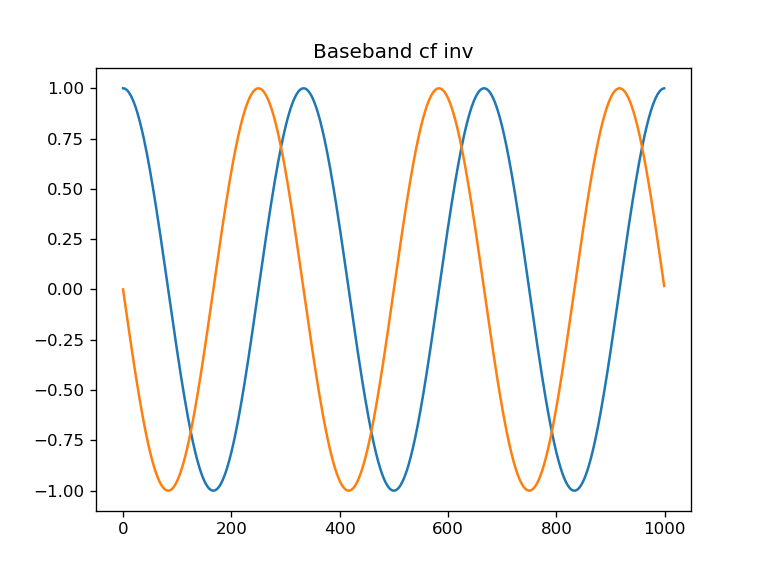

In [105]:

pyplot.close("all")
pyplot.title("Baseband cf inv")
pyplot.plot(np.real(baseband_inv[:1000]))
pyplot.plot(np.imag(baseband_inv[:1000]))
pyplot.show()

<IPython.core.display.Javascript object>


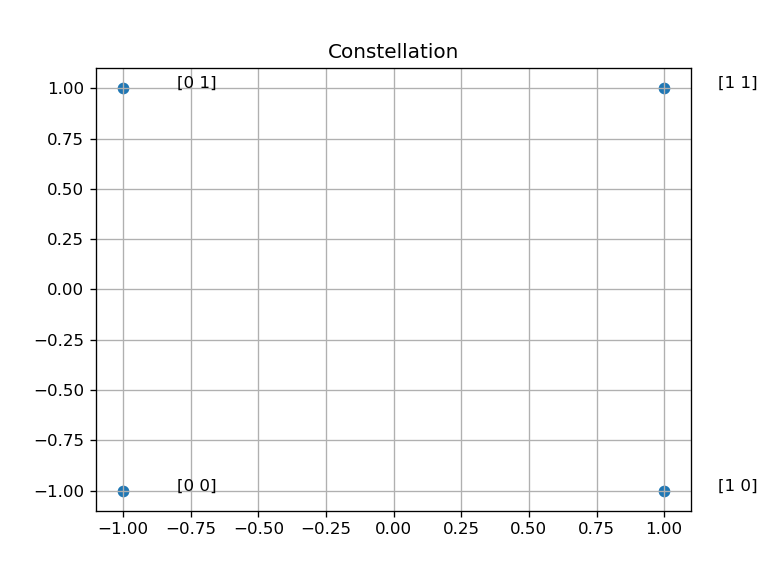

C:\Users\babc226\Anaconda3\envs\py38i\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


array([-0.70710678-0.70710678j, -0.70710678+0.70710678j,
        0.70710678-0.70710678j,  0.70710678+0.70710678j])

In [106]:
m = QAMModem(nsymbols)
con = m.constellation
con = con/np.max(np.abs(con))  # power normalizing


#
# There is non-unit amplitude in this constellation plot which can cause issues.
#
pyplot.close("all")
m.plot_constellation()
con


<IPython.core.display.Javascript object>


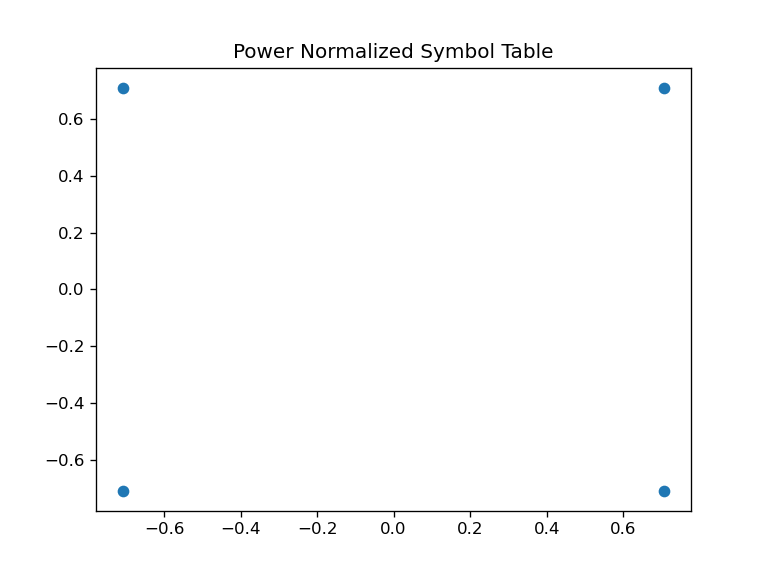

In [107]:
pyplot.close("all")
pyplot.scatter(np.real(con), np.imag(con))
pyplot.title("Power Normalized Symbol Table")
pyplot.show()

In [108]:
symbol_message = np.random.randint(0, nsymbols, message_len)
symbol_message[:10]
message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
message_with_repeats[:30]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 3, 3, 3, 3, 3])

In [109]:
#
# An IQ encoding of a message is just a symbol lookup table
#

iq_encoded_message = con[message_with_repeats]
iq_encoded_message

#
#
#

array([-0.70710678-0.70710678j, -0.70710678-0.70710678j,
       -0.70710678-0.70710678j, ..., -0.70710678+0.70710678j,
       -0.70710678+0.70710678j, -0.70710678+0.70710678j])

15000
[-0.42561712-1.11928639j -0.73638649+0.68467314j -0.24360057-0.6832371j
 ... -0.14153864-0.86810986j -0.97169095-0.72600665j
 -1.25600657+0.28163343j]


<IPython.core.display.Javascript object>


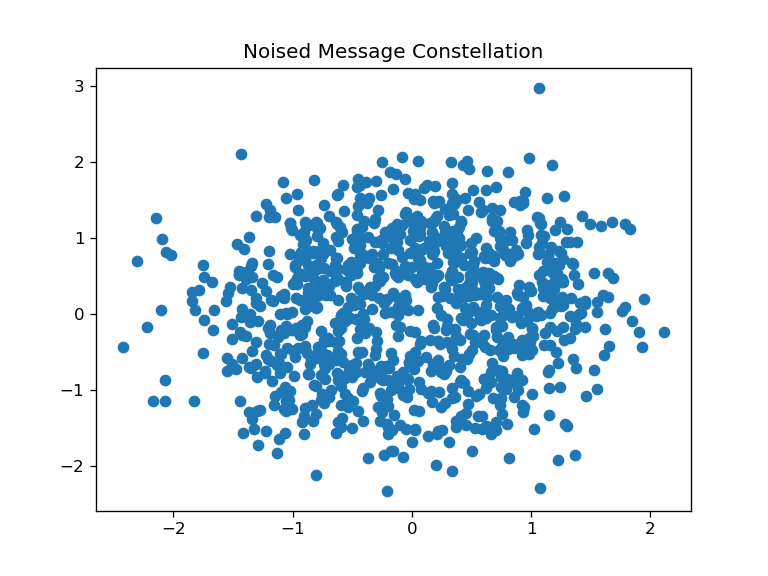

In [110]:
#
# Modulate the encoding unto the baseband cf
#
modulated = iq_encoded_message*baseband_signal
print(len(modulated))
#
# Create noise for our channel model
#
noise = np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) +  1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
print(noise)
#
# Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
#
channel_iq = modulated + noise

plt.close("all")
plt.scatter(np.real(channel_iq[:1000]), np.imag(channel_iq[:1000]))
plt.title("Noised Message Constellation")
plt.show()


<IPython.core.display.Javascript object>


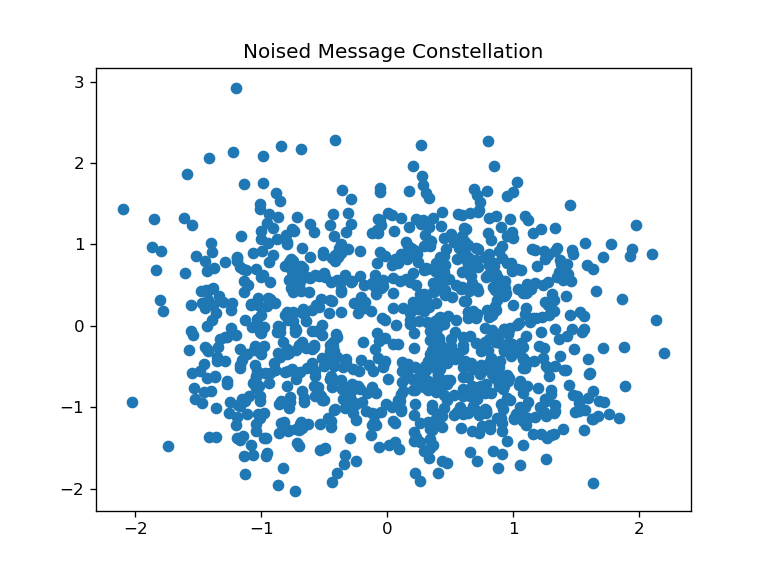

In [111]:
#
# Unmodulate with baseband inv to get the original modulation with noise effects
#
unmodulated = channel_iq*baseband_inv
plt.close("all")
plt.scatter(np.real(unmodulated[:1000]), np.imag(unmodulated[:1000]))
plt.title("Noised Message Constellation")
plt.show()

<IPython.core.display.Javascript object>


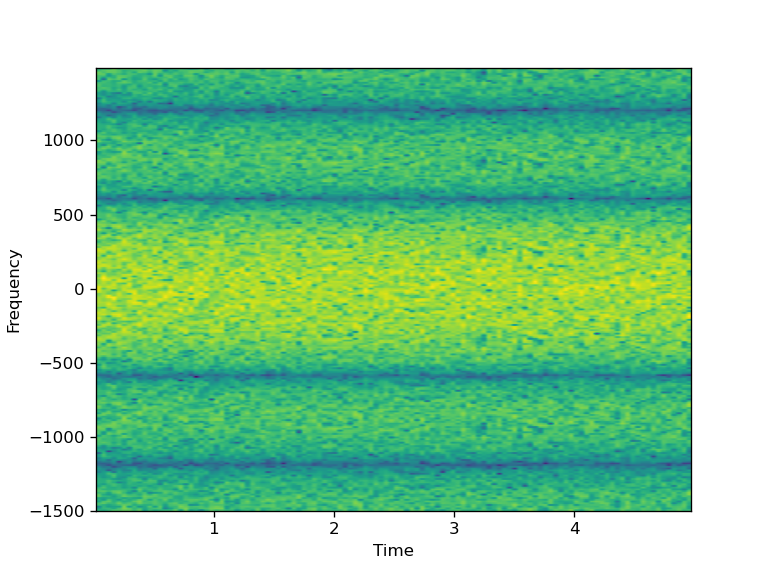

In [112]:
fftLen = len(modulated)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / baseband_carrier_freq * (len(modulated))
plt.close("all")
pyplot.specgram(modulated, Fs=baseband_carrier_freq)
pyplot.xlabel("Time")
pyplot.ylabel("Frequency")
pyplot.show()
#
# Pretty sure my units are screwed up here...
#

<IPython.core.display.Javascript object>


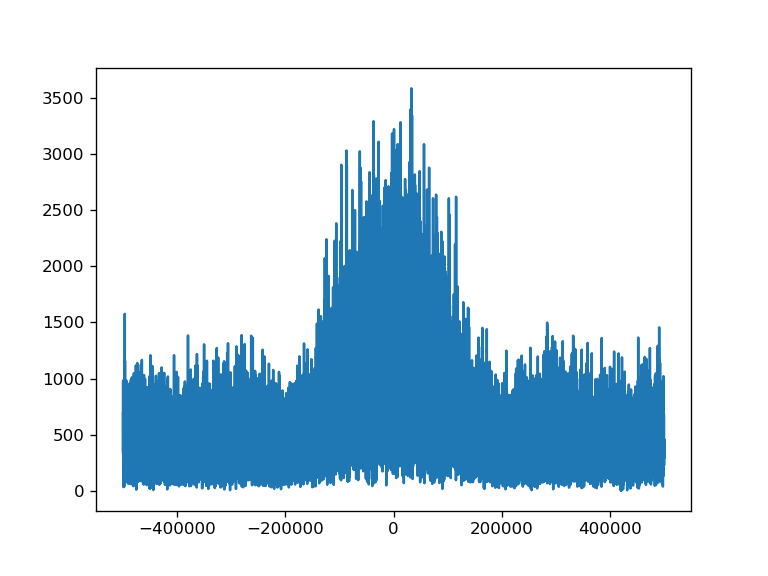

In [113]:
f = spectrum(unmodulated)
plt.close("all")
pyplot.plot(freqs, np.abs(f))
pyplot.show()

# Cycle Autocorrelation Function (CAF)

## Testing on modulated signal first... i.e. zero noised channel

1. First calculate the asymetric CAF $\hat{R}_{\tau}^{\alpha}$
2. Place in the frequency domain, apply a shift of $-\pi \alpha \tau $ to all freqs alpha and calculate the symmetric CAF



In [198]:
from scipy import signal
x = unmodulated
auto_cor = signal.correlate(x,
                       x,
                       mode="same")/len(x)


lags = signal.correlation_lags(x.size, x.size, mode="same")


conj_auto_cor = signal.correlate(x,
                       np.conj(x),
                       mode="same")/len(x)

asym_caf = np.fft.fftshift(np.fft.fft(auto_cor))
conj_asym_caf = np.fft.fftshift(np.fft.fft(conj_auto_cor))


<IPython.core.display.Javascript object>


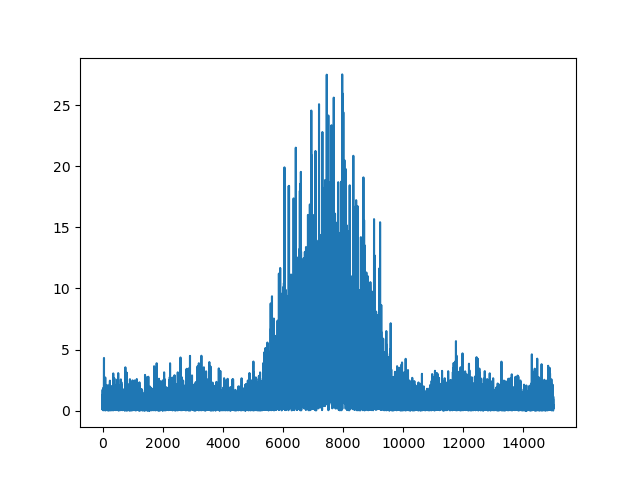

In [199]:
plt.close("all")
plt.plot(np.abs(asym_caf))
plt.show()

<IPython.core.display.Javascript object>


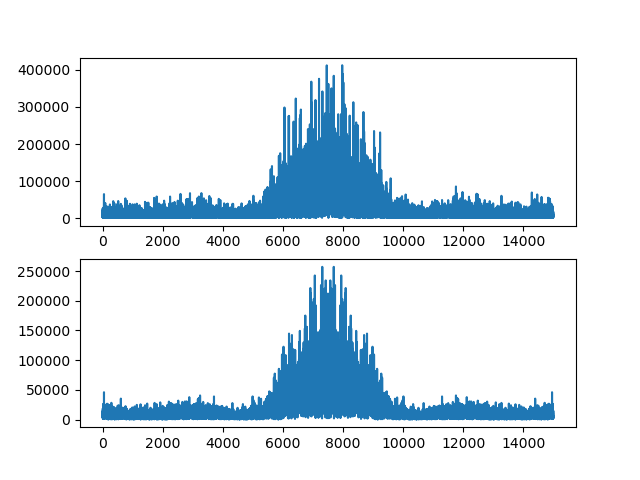

In [190]:
plot_m([np.abs(asym_caf), np.abs(conj_asym_caf) ])


<IPython.core.display.Javascript object>


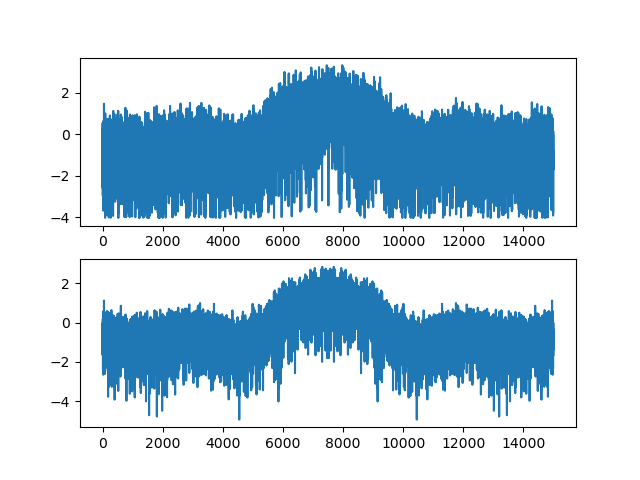

In [200]:

# phi = np.outer(freqs, lags) # not enough memory... needs 17.2 GiB
# (np.exp(1j*np.pi*phi)*
caf = np.fft.ifftshift(asym_caf) # rotate by some number to convert to symetric caf... 
conj_caf = np.fft.ifftshift(conj_asym_caf) # rotate by some number to convert to symetric caf... 

objs = [np.log(np.fft.fftshift(np.abs(caf))),  np.log(np.fft.fftshift(np.abs(conj_caf)))]
plot_m(objs)

[    3     6     8 ... 14991 14993 14997]
[-499800.         -499600.         -499466.66666667 ...  499400.
  499533.33333333  499800.        ]


<IPython.core.display.Javascript object>


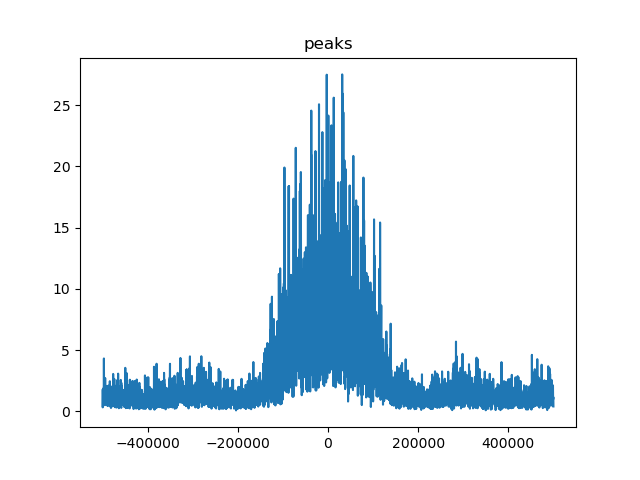

In [201]:
# trying to estimate peaks...
peaks_caf =  find_peaks(np.log10(np.fft.fftshift(np.abs(caf))))[0]
print(peaks_caf)
max_peak_caf = np.fft.fftshift(np.abs(caf))[peaks_caf]
print(freqs[peaks_caf])


plt.close("all")
plt.title("peaks")
plt.plot(freqs[peaks_caf], max_peak_caf)
plt.show()

                    0                0.0002Hz                0.0004Hz  \
0 -2.052649+4.137598j  224.069546+408.076779j  173.353909-181.157078j   
1  3.208938+5.244804j  140.934363+130.250349j   151.144682-77.904696j   
2 -0.785457+6.718837j   129.330023+74.985957j   137.027123-58.144709j   
3  3.824821+6.191102j   113.495199+59.470494j   135.264792-52.109220j   
4 -1.977099+5.340613j  93.0609600+46.7341210j   136.622461-45.403736j   

                 0.0005Hz                0.0007Hz  
0  165.293449+219.557356j  298.761160+194.301743j  
1 -137.160292+133.639082j  107.030483+349.613214j  
2  -6.278570+014.4422070j -147.514325+420.002584j  
3   112.649307-60.587497j -268.041875+105.817716j  
4   69.329483+256.351337j -338.9628201+7.5690390j  


<IPython.core.display.Javascript object>


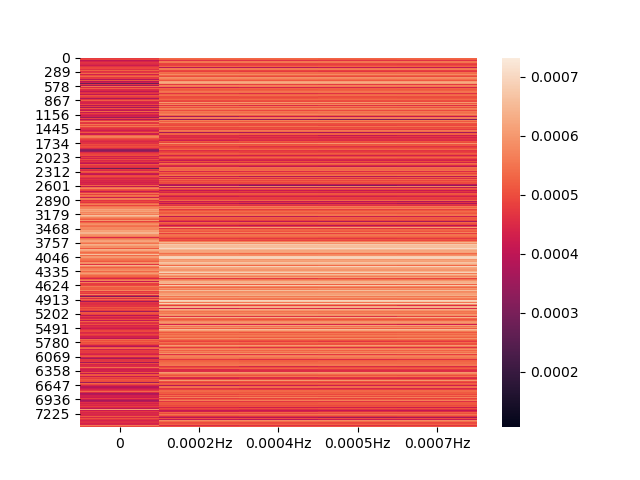

In [195]:
import pandas as pd
import seaborn as sns

def psd(x):
    return np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))/len(x)

def spec_coherence_function(x, psd):
    """
    x is columns associated with the cyclic autocorrelation function
    """
    return np.fft.fftshift(np.fft.fft(x))/psd
    

## Testing CAF* 
lags = peaks_caf  # filter to approximate tau shifts that maximize periodic components

half_freq = np.fft.ifftshift(freqs)[0:len(freqs)//2]

if 0 not in lags:
    data = {0: np.fft.ifft(np.fft.fft(signal.fftconvolve(x, x)))[0:len(half_freq)] }
else:
    data = {}
# Have not checked if tau is in half freqs !!
for tau in lags[0:4]:
    y_tau = np.roll(x, tau)
    asym_caf_t = signal.fftconvolve(y_tau, y_tau)
    data[f"{np.round(half_freq[tau]*dt, 4)}Hz"] = np.fft.ifft(np.exp(1j*np.pi*half_freq*tau)*np.fft.fft(asym_caf_t, n=len(freqs))[0:len(half_freq)])
    pass
# exp( i(-2pift +1pif*Tau) ) --> exp(-2ipif(t-Tau/2))

df = pd.DataFrame(data) # df contains the symmetric CAF function for a selected tau shifts
df_conj.index = [f"{np.round(f*dt, 4)}Hz" for f in half_freq]



## Testing CAF* transform to get scf...
print(df.head())
plt.close("all")
sns.heatmap(df.transform(psd))
plt.show()




[    1     3     5 ... 14990 14995 14997]


<IPython.core.display.Javascript object>


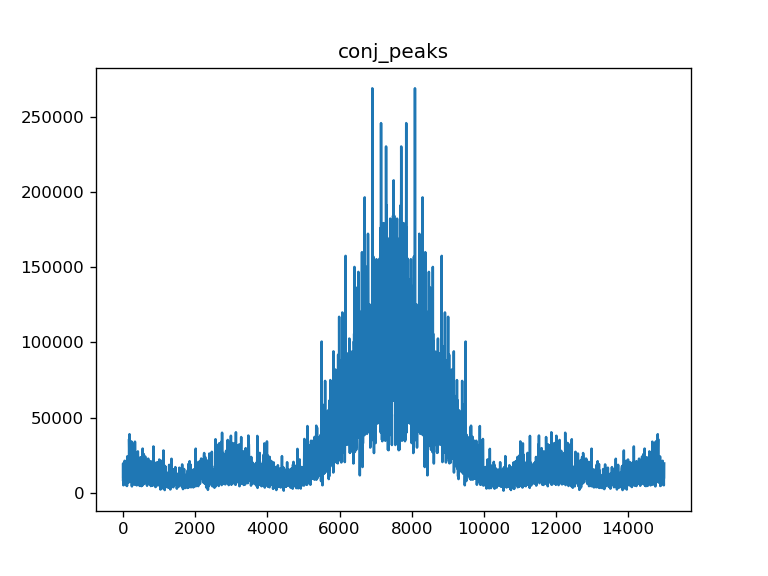

In [77]:
# trying to estimate peaks...
peaks_ccaf =  find_peaks(np.log10(np.fft.fftshift(np.abs(conj_caf))))[0]
print(peaks_ccaf)
max_peak_conj_caf = np.fft.fftshift(np.abs(conj_caf))[peaks_ccaf]
plt.close("all")
plt.plot(peaks_ccaf, max_peak_conj_caf)
plt.title("conj_peaks")
plt.show()

<IPython.core.display.Javascript object>


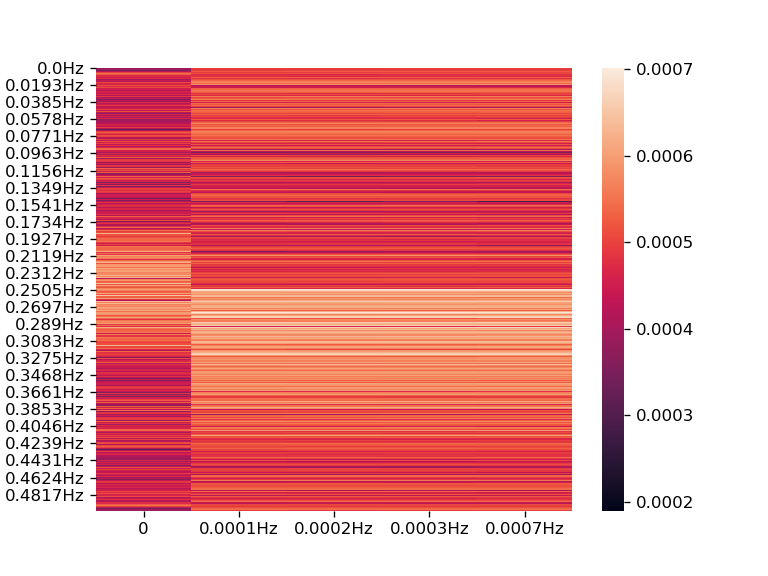

In [99]:
## testing Spectral Coherence function.... 


## testing conj CAF 

def psd(x):
    return np.fft.fftshift(np.log10(np.abs(np.fft.fft(x))))/len(x)

def spec_coherence_function(x, psd):
    """
    x is columns associated with the cyclic autocorrelation function
    """
    return np.fft.fftshift(np.fft.fft(x))/psd
    

## Testing CAF* 
lags = peaks_ccaf  # filter to approximate tau shifts that maximize periodic components

half_freq = np.fft.ifftshift(freqs)[0:len(freqs)//2]

if 0 not in lags:
    data = {0: np.fft.ifft(np.fft.fft(signal.fftconvolve(x, np.conj(x))))[0:len(half_freq)] }
else:
    data = {}
# Have not checked if tau is in half freqs !!
for tau in lags[0:4]:
    y_tau = np.roll(x, tau)
    asym_caf_t = signal.fftconvolve(y_tau, np.conj(y_tau))
    data[f"{np.round(half_freq[tau]*dt, 4)}Hz"] = np.fft.ifft(np.exp(1j*np.pi*half_freq*tau)*np.fft.fft(asym_caf_t, n=len(freqs))[0:len(half_freq)])
    pass
# exp( i(-2pift +1pif*Tau) ) --> exp(-2ipif(t-Tau/2))

df_conj = pd.DataFrame(data) # df contains the symmetric conj CAF function for a selected tau shifts
df_conj.index = [f"{np.round(f*dt, 4)}Hz" for f in half_freq]


## Testing conj CAF* transform to get scf...
plt.close("all")
sns.heatmap(df_conj.transform(psd), fmt='.2g')
plt.show()



In [79]:
print(df_conj.transform(psd).describe())

        0.000000     66.666667    200.000000   333.333333   666.666667
count  7500.000000  7500.000000  7500.000000  7500.000000  7500.000000
mean      0.000477     0.000518     0.000518     0.000518     0.000518
std       0.000062     0.000062     0.000062     0.000062     0.000062
min       0.000202     0.000275     0.000251     0.000189     0.000234
25%       0.000436     0.000477     0.000477     0.000477     0.000477
50%       0.000474     0.000512     0.000512     0.000512     0.000512
75%       0.000516     0.000556     0.000556     0.000555     0.000555
max       0.000670     0.000701     0.000701     0.000701     0.000700


In [100]:
test = signal.fftconvolve(iq_encoded_message, iq_encoded_message)

dft = pd.DataFrame(test)
dft.index = [f"{np.round(f*dt, 4)}Hz" for f in half_freq]

plt.close("all")
sns.heatmap(dft.transform(psd))
plt.show()
print(dft.transform(psd).describe())

ValueError: Length mismatch: Expected axis has 29999 elements, new values have 7500 elements

#  cyclic periodogram


<IPython.core.display.Javascript object>


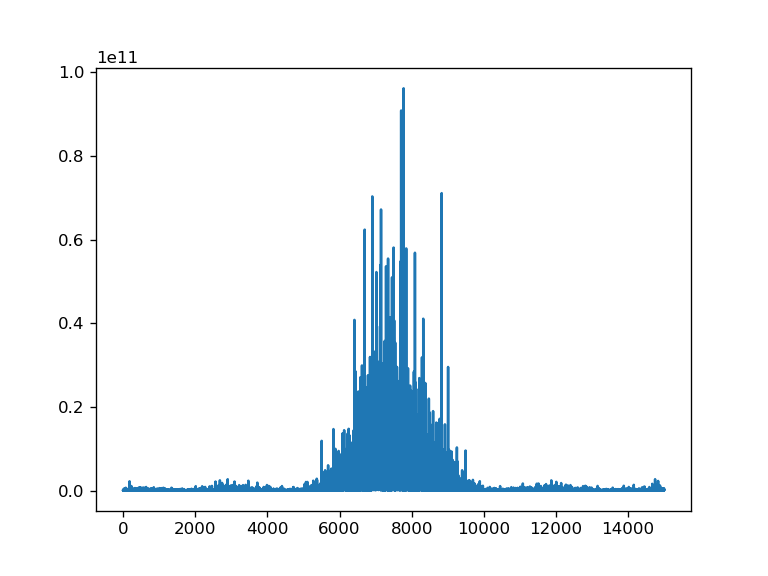

In [81]:
cyclic_per = caf*conj_caf
plt.close("all")
plt.plot(np.fft.fftshift(np.abs(cyclic_per)))
plt.show()

<IPython.core.display.Javascript object>


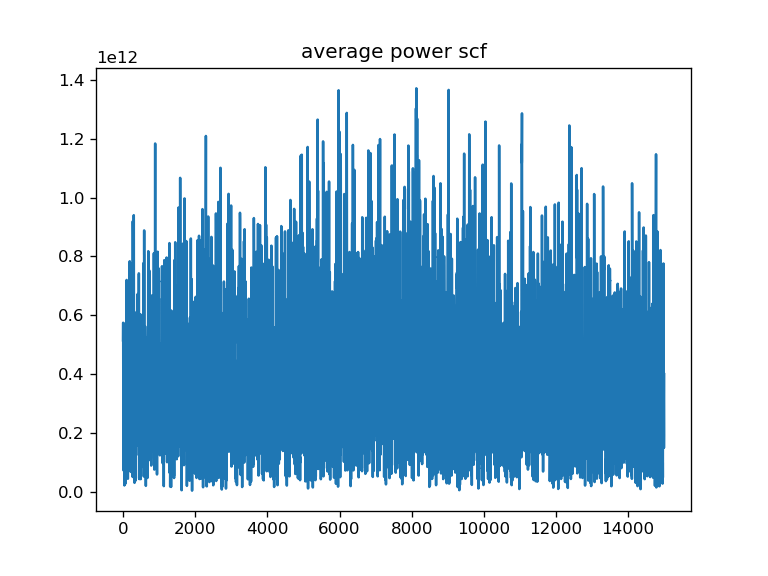

max power at 8130


In [82]:

scf = np.fft.fftshift(np.fft.fft(cyclic_per))
plt.close("all")
plt.plot(np.abs(scf))
plt.title("average power scf")
plt.show()

max_power = np.argmax(2*np.log10(np.abs(scf))/len(scf))
print(f"max power at {max_power}")




<p style="padding-left: 30px;"><img src="https://s0.wp.com/latex.php?latex=%5Cdisplaystyle+R_x%28t%2C+%5Cboldsymbol%7B%5Ctau%7D%29+%3D+%5Cfrac%7B1%7D%7B4%7D+R_s%28t%2C+%5Cboldsymbol%7B%5Ctau%7D%29+%5Cleft%5B+e%5E%7Bi2%5Cpi+f_c%282t+%2B+%5Ctau_1+%2B+%5Ctau_2%29+%2B+i2%5Cphi%7D+%2B+e%5E%7Bi2%5Cpi+f_c%28%5Ctau_1+-+%5Ctau_2%29%7D+%2B+e%5E%7Bi2%5Cpi+f_c+%28%5Ctau_2+-+%5Ctau_1%29%7D+%2B+e%5E%7B-i2%5Cpi+f_c+%282t+%2B+%5Ctau_1+%2B+%5Ctau_2%29%7D+%5Cright%5D.+%5Chfill+%2814%29&amp;bg=ffffff&amp;fg=1a1a1a&amp;s=0&amp;c=20201002" alt="\displaystyle R_x(t, \boldsymbol{\tau}) = \frac{1}{4} R_s(t, \boldsymbol{\tau}) \left[ e^{i2\pi f_c(2t + \tau_1 + \tau_2) + i2\phi} + e^{i2\pi f_c(\tau_1 - \tau_2)} + e^{i2\pi f_c (\tau_2 - \tau_1)} + e^{-i2\pi f_c (2t + \tau_1 + \tau_2)} \right]. \hfill (14)" class="latex jetpack-lazy-image jetpack-lazy-image--handled" data-lazy-loaded="1" loading="eager"><noscript>

# if $s(t)$ is cyclostationary with cycle frequencies $\alpha_s$, then $x(t)$ will have cycle frequencies of

1. $\alpha_s$
2. $\alpha_s + 2 f_c$
3. $\alpha_s - 2 f_c$

### Refrence https://cyclostationary.blog/2016/02/29/conjugation-configurations/

For example, if the real signal $s(t)$ is a pulse-amplitude modulated (PAM) signal, it will have cycle frequencies $\alpha_s \in \{k/T_0\}$, where $1/T_0$ is the symbol rate of the PAM signal. So the middle two terms above give us those cycle frequencies, the first term gives us $2f_c + k/T_0$ (which includes $2f_c$ itself when $k=0$), and the last term gives us $-2f_c + k/T_0$. BPSK is such a PAM signal.

In [30]:
T_0 = 1/samples_per_second
fc = baseband_carrier_freq
test_f = np.fft.ifftshift(np.fft.fftfreq(duration*samples_per_second, dt))
print(T_0, fc)
print(len(scf), len(scf)*T_0)
print(dt, T_0)


scf_freqs = np.fft.fftfreq(duration*samples_per_second, duration*T_0)

sort = np.argsort(scf_freqs)
freqs = scf_freqs[sort]
print(freqs)

print(np.abs(freqs-test_f))

alphas = set(np.arange(0, duration, T_0))
alpha_2 = set(np.arange(0, duration, T_0 + 2*fc))
alpha_3 = set(np.arange(0, duration, T_0 - 2*fc))

print(len(alphas))
alphas.union(alpha_2)
print(len(alphas))
alphas.union(alpha_3)
print(len(alphas))

alpha = np.asarray(list(alphas), dtype=np.float64)
print(type(alpha), type(freqs))


0.001 3000


NameError: name 'scf' is not defined

In [ ]:
params = {
    'nsymbols':nsymbols,
    'repeats_per_symbol'   :  repeats_per_symbol,
    'samples_per_second'  :   samples_per_second,
    'message_len'   :   message_len ,
    'total_samples'  :  total_samples ,
    'baseband_carrier_freq' :   baseband_carrier_freq,
    'noise_sd'  :   noise_sd ,
    'duration' :  duration, 
    'time'  :   time, 
    'dt'  :   dt,
    'freqs'  :   freqs
    }
def c_caf(x):
    auto_cor = signal.correlate(x/np.max(np.abs(x)),
                       x/np.max(np.abs(x)),
                       mode="same")
    lags = signal.correlation_lags(x.size, x.size, mode="same")
    conj_auto_cor = signal.correlate(np.conj(x)/np.max(np.abs(x)),
                           np.conj(x)/np.max(np.abs(x)),
                           mode="same")
    asym_caf = np.fft.fftshift(np.fft.fft(auto_cor))
    conj_asym_caf = np.fft.fftshift(np.fft.fft(conj_auto_cor))
    
    # phi = np.outer(freqs, lags) # not enough memory... needs 17.2 GiB
    # (np.exp(1j*np.pi*phi)*
    caf = np.fft.ifftshift(asym_caf) # rotate by some number to convert to symetric caf... 
    conj_caf = np.fft.ifftshift(conj_asym_caf) # rotate by some number to convert to symetric caf... 


    return caf, conj_caf
    
    
def gen_df(modulation=2, params={}):
    print("generating df... ")
    # set params
    nsymbols =  params["nsymbols"]
    repeats_per_symbol = params["repeats_per_symbol"]
    samples_per_second = params["samples_per_second"]
    message_len = params["message_len"]
    total_samples = params["total_samples"]
    baseband_carrier_freq = params["baseband_carrier_freq"]
    noise_sd = params["noise_sd"]
    duration = params["duration"]
    time =  params["time"]
    dt = params["dt"]
    freqs = params["freqs"]
    
    # define values...     
    baseband_signal =  np.exp(1j*2*np.pi*time*baseband_carrier_freq)
    baseband_inv = np.exp(-1j*2*np.pi*time*baseband_carrier_freq)
    # define constellation
    m = QAMModem(nsymbols)
    con = m.constellation
    con = con/np.max(np.abs(con))  # power normalizing
    # An IQ encoding of a message is just a symbol lookup table
    iq_encoded_message = con[message_with_repeats]
    iq_encoded_message
    # Modulate the encoding unto the baseband cf
    modulated = iq_encoded_message*baseband_signal
    noise = np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) + \
        1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
    
    # Channel refers to the idea of a channel model with experimental effects.  Here AWGN.
    channel_iq = modulated + noise
    # Unmodulate with baseband inv to get the original modulation with noise effects
    unmodulated = channel_iq*baseband_inv
    # trying to estimate peaks...
    ## caf...
    peaks_caf =  find_peaks(np.log10(np.fft.fftshift(np.abs(caf))))[0]
    max_peak_caf = np.fft.fftshift(np.abs(caf))[peaks_caf]
    ## conj_caf...
    peaks_ccaf =  find_peaks(np.log10(np.fft.fftshift(np.abs(conj_caf))))[0]
    max_peak_conj_caf = np.fft.fftshift(np.abs(conj_caf))[peaks_ccaf]
    
    
    df = pd.DataFrame()
    
    
gen_df(modulation=2, params=params)    
    